# Weighted Portfolio

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
weights = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}
symbols = list(weights.keys())
directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)
ts

,SPY_high,SPY_low,SPY_close,TLT_high,TLT_low,TLT_close,GLD_high,GLD_low,GLD_close,TLT_SHRT_high,TLT_SHRT_low,TLT_SHRT_close
date,,,,,,,,,,,,
1993-01-29,26.10,25.97,26.08,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-02-01,26.27,26.10,26.27,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-02-02,26.34,26.19,26.32,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-02-03,26.62,26.34,26.60,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-02-04,26.77,26.39,26.71,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-12,354.02,349.06,352.43,160.68,160.11,160.60,180.83,180.19,180.56,160.68,160.11,160.60
2020-10-13,352.47,349.09,350.13,161.83,161.18,161.75,178.60,177.10,177.72,161.83,161.18,161.75
2020-10-14,351.93,347.14,347.93,162.75,161.97,162.12,179.59,178.27,178.27,162.75,161.97,162.12


In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital, margin=2)
pf.TradeLog.instance

{'SPY': <pinkfish.trade.TradeLog at 0x7fb7dac4b220>,
 'TLT': <pinkfish.trade.TradeLog at 0x7fb7dac4b250>,
 'GLD': <pinkfish.trade.TradeLog at 0x7fb7dac4b280>,
 'TLT_SHRT': <pinkfish.trade.TradeLog at 0x7fb7dac4b2b0>}

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)
    p = portfolio.get_prices(row, fields=['close'])

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            close = p[symbol]['close']
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, close, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,86.60,115,entry,LONG,SPY
1,2004-12-01,1,51.30,116,entry,LONG,TLT
2,2004-12-01,2,45.38,44,entry,LONG,GLD
3,2004-12-01,3,51.30,38,entry,SHRT,TLT_SHRT
4,2005-01-03,4,52.86,1,exit,LONG,TLT
5,2005-01-03,5,43.02,3,entry,LONG,GLD
6,2005-02-01,6,86.78,1,entry,LONG,SPY
7,2005-02-01,7,54.54,4,exit,LONG,TLT
8,2005-02-01,8,42.10,1,entry,LONG,GLD
9,2005-02-01,9,54.54,1,exit,SHRT,TLT_SHRT


In [11]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
519,2017-05-01,111.95,2020-10-01,163.36,-51.41,-51.41,1,65746.10,SHRT,TLT_SHRT
520,2017-05-01,119.67,2020-10-16,178.30,58.63,58.63,1,65804.73,LONG,GLD
521,2017-06-01,115.03,2020-10-01,163.36,48.33,48.33,1,65853.05,LONG,TLT
522,2017-06-01,227.65,2020-10-16,347.29,119.64,358.92,3,66211.98,LONG,SPY
523,2017-06-01,120.72,2020-10-16,178.30,57.58,115.16,2,66327.14,LONG,GLD
...,...,...,...,...,...,...,...,...,...,...
614,2020-08-03,169.58,2020-10-16,161.39,-8.19,-131.08,16,81206.61,LONG,TLT
615,2020-08-03,169.58,2020-10-16,161.39,8.19,49.16,6,81255.77,SHRT,TLT_SHRT
616,2020-09-01,163.69,2020-10-16,161.39,-2.30,-69.01,30,81186.75,LONG,TLT
617,2020-09-01,185.05,2020-10-16,178.30,-6.75,-33.75,5,81153.00,LONG,GLD


In [12]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-10-12,92579.35,92579.35,92579.35,796,-81007.74,1.88,-
2020-10-13,91943.99,91943.99,91943.99,796,-81007.74,1.88,-
2020-10-14,91500.49,91500.49,91500.49,796,-81007.74,1.89,-
2020-10-15,91390.72,91390.72,91390.72,796,-81007.74,1.89,-
2020-10-16,91176.01,91176.01,91176.01,0,91176.01,1.00,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                    2004-11-18
end                                                      2020-10-16
beginning_balance                                             10000
ending_balance                                             91176.01
total_net_profit                                           81176.01
gross_profit                                               91607.47
gross_loss                                                -10431.46
profit_factor                                                  8.78
return_on_initial_capital                                    811.76
annual_return_rate                                            14.90
trading_period                           15 years 10 months 28 days
pct_time_in_market                                            99.80
margin                                                            2
avg_leverage                                                   1.93
max_leverage                                    

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

2004-11-18 00:00:00 BUY  115 SPY @ 86.25
2020-10-16 00:00:00 SELL 115 SPY @ 347.29


In [15]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [16]:
benchmark.stats = benchmark.get_stats()

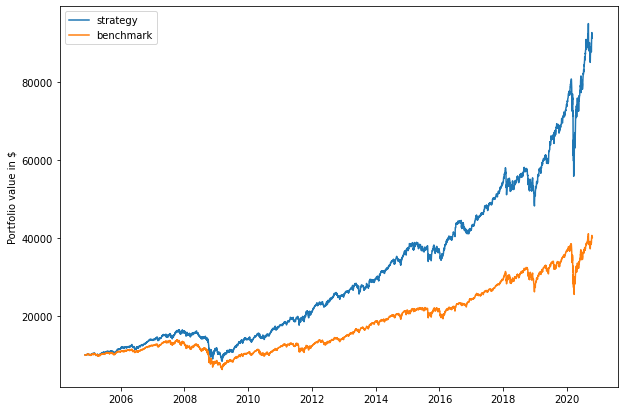

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

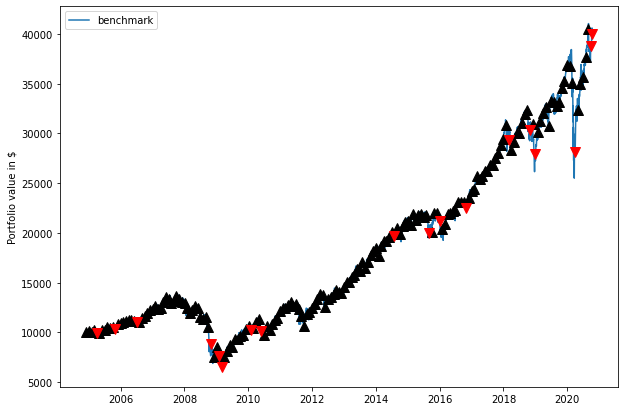

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$91,176.01","$40,019.79"
total_net_profit,"$81,176.01","$30,019.79"
gross_profit,"$91,607.47","$30,019.79"
gross_loss,"-$10,431.46",$0.00


,strategy,benchmark
annual_return_rate,14.90,9.11
max_closed_out_drawdown,-49.01,-54.87
drawdown_annualized_return,-3.29,-6.02
drawdown_recovery,-1.36,-1.42
best_month,30.84,23.31
worst_month,-30.88,-30.92
sharpe_ratio,0.85,0.55
sortino_ratio,1.05,0.65
monthly_std,4.55,4.55
annual_std,15.69,15.39


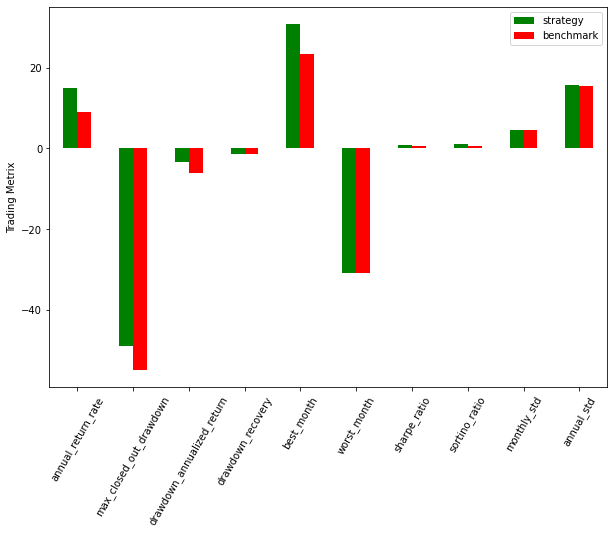

In [20]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df